In [1]:
import os, shutil, glob, warnings, os
import argparse
import sys
from datetime import datetime

import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision
from skimage import exposure, color, io, img_as_float, img_as_ubyte
from skimage.util import view_as_windows, pad, montage
from PIL import Image, ImageFilter
import imagej

from math import log10, log, exp, e, log2
import pandas as pd
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler

import datasets as data
import srmodels_full as models

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [51]:
def data_loader(model_config, csv='train'):
    if csv=='train':
        transformed_dataset = data.Pair_Dataset(csv_file=data.compress_csv_path(csv, resolution=model_config["resolution"]),
                                                   transform=data.Compose([
                                                       data.ToTensor()
                                               ]))
        dataloader = DataLoader(transformed_dataset, batch_size=model_config["batch-size"], shuffle=True, num_workers=model_config["threads"])
    if csv=='valid':
        transformed_dataset = data.Pair_Dataset(csv_file=data.compress_csv_path(csv, resolution=model_config["resolution"]),
                                                   transform=data.Compose([
                                                       data.ToTensor()
                                               ]))
        dataloader = DataLoader(transformed_dataset, batch_size=model_config["batch-size"], shuffle=True, num_workers=model_config["threads"])
    return dataloader

def train(model_config, epoch, run, p, dataloader, criterion):
    epoch_loss = 0
    gan_loss = 0
    total_loss = 0
    dis_loss = 0
    generator.train()
    device = next(generator.parameters()).device
    for iteration, batch in enumerate(dataloader):
        noisy = Variable(batch['input'].float().to(device), requires_grad=False)
        ### generate 2d dropout
        drop_mask = F.dropout(Variable(torch.ones(noisy.shape).to(device), requires_grad=False), p=p, inplace=True) # p percent zero, keep
        spotted = torch.mul(noisy, drop_mask)
        
        optimizer_G.zero_grad()
        clean = generator(spotted)
        loss_pixel = torch.mean(torch.mul(criterion(clean, noisy), 1/(1-p)-drop_mask)) / p                    
        loss_pixel.backward()
        optimizer_G.step()
        
        epoch_loss = epoch_loss + loss_pixel.item()
        sys.stdout.write('\r[%d/%d][%d/%d] Loss: %.4f' 
                             % (epoch, model_config["epochs"], iteration, len(dataloader), loss_pixel.item()))
    print("\n ===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))
    
    g_path = os.path.join('weights-self', run, 'generator.pth')
    os.makedirs(os.path.join('weights-self', run), exist_ok=True)
    torch.save(generator.state_dict(), g_path)
    
def test(generator, p, dataloader, criterion):
    with torch.no_grad():
        epoch_loss = 0
        epoch_snr = 0
        generator.eval()
        device = next(generator.parameters()).device
        for iteration, batch in enumerate(dataloader):
            noisy = Variable(batch['input'].float().to(device), requires_grad=False)
            drop_mask = F.dropout(Variable(torch.ones(noisy.shape).to(device), requires_grad=False), p=p, inplace=True)
            spotted = torch.mul(noisy, drop_mask)
            clean = generator(spotted) # N x C x H x W
            ### loss
            loss = torch.mean(torch.mul(criterion(clean, noisy), 1/(1-p)-drop_mask)) / p
            ### SNR
            signal = torch.mean(clean, dim=(1, 2, 3)) # N
            noise = torch.std(clean, dim=(1, 2, 3))
            snr = 10*np.log10(np.divide(signal.cpu().numpy(), noise.cpu().numpy()))
            epoch_snr = epoch_snr + np.mean(snr)
            epoch_loss = epoch_loss + loss.item()
        return epoch_loss / len(dataloader), epoch_snr / len(dataloader)
    
def print_output(trained_model, p, t, dataloader_valid):
    generator.eval()
    device = next(generator.parameters()).device
    os.makedirs('print', exist_ok=True)
    with torch.no_grad():      
        print("===> noisy and clean:")
        for iteration, batch in enumerate(dataloader_valid):     
            imgs_input = Variable(batch['input'].float().to(device))
            pass_times = int(1/p * t)
            tensor_hyper = torch.zeros((imgs_input.shape[0], imgs_input.shape[1], imgs_input.shape[2], imgs_input.shape[3]))
            for i in range(pass_times):
                drop_mask = F.dropout(Variable(torch.ones(imgs_input.shape).to(device), requires_grad=False), p=p, inplace=True)
                spotted = torch.mul(imgs_input, drop_mask) 
                prediction = trained_model(spotted)
                prediction = torch.mul(prediction, 1/(1-p)-drop_mask) / p
                tensor_hyper = tensor_hyper + prediction.cpu()
            prediction = tensor_hyper / pass_times   
            imgs_input = imgs_input[:, :, :, :]
            prediction = prediction[:, :, :, :]
            plt.figure(figsize=(20, 6))
            grid = utils.make_grid(imgs_input).cpu()
            utils.save_image(grid, 'print/input.tif')
            input_downsampled = grid.numpy().transpose((1, 2, 0))
            plt.imshow(input_downsampled, interpolation='bicubic')
            plt.axis('off') 
            plt.figure(figsize=(20, 6))
            grid = utils.make_grid(prediction).cpu()
            utils.save_image(grid, 'print/output.tif')
            prediction = np.clip(grid.numpy().transpose((1, 2, 0)), 0, 1)
            plt.imshow(prediction, interpolation='bicubic')
            plt.axis('off')                                     
            break

In [15]:
model_config = {
    "image-channel" : 1,
    "batch-size" : 32,
    "epochs" : 100,
    "learning-rate" : 0.0002,
    "resolution" : 512,
    "dropout-rate" : 0.1,
    "run-from" : None,
    "cnn-base-channel" : 8,
    "normalization" : "instance",
    "gpu" : True,
    "threads" : 4
}

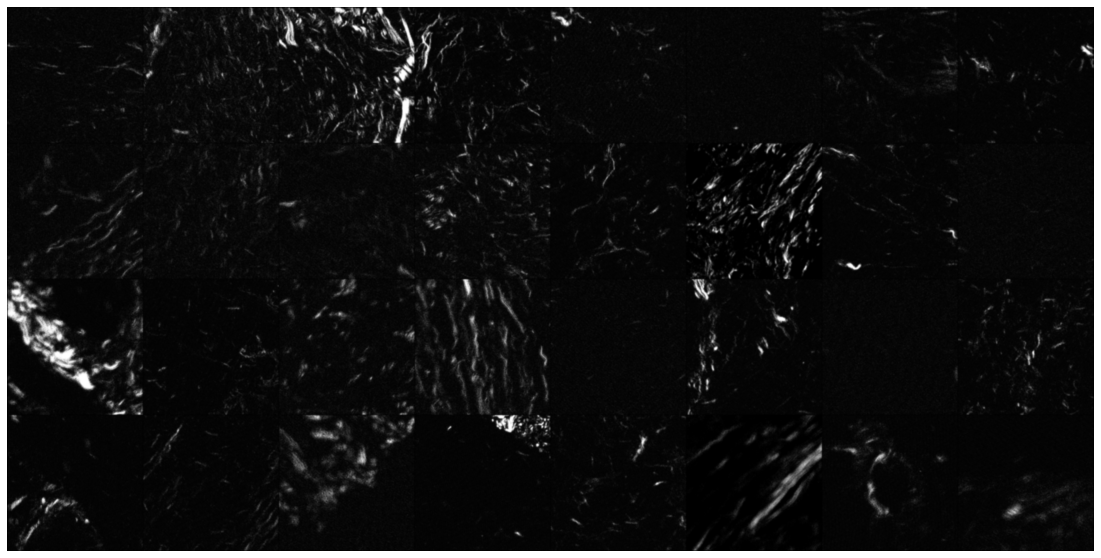

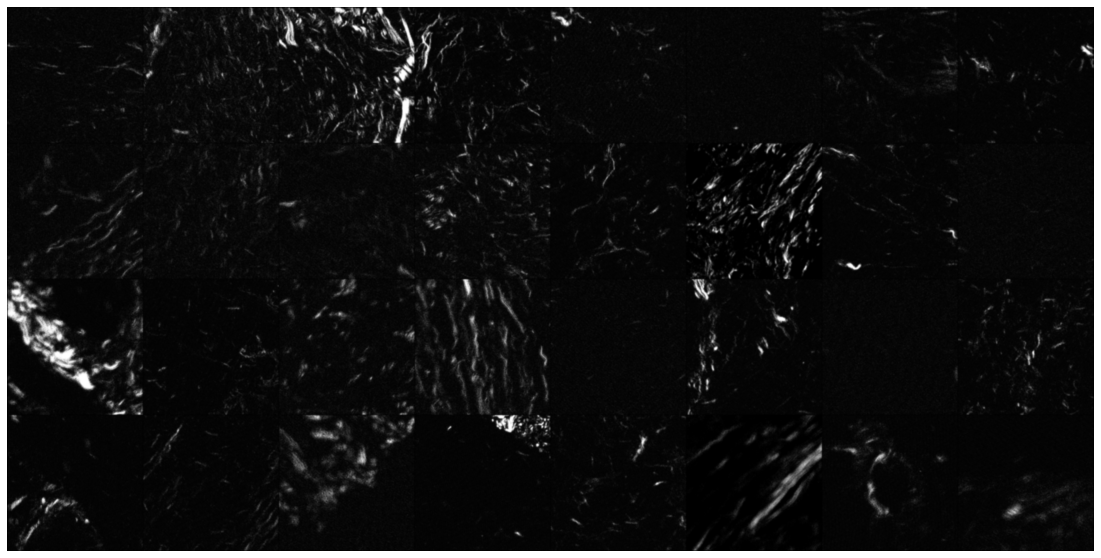

In [20]:
if model_config["gpu"]:
    device = torch.device('cuda:0')
else:
    device = 'cpu'
data.generate_compress_csv(resolution=model_config["resolution"])
valid_dataset = data_loader(model_config, 'train')
data.show_patch(valid_dataset, 0)
generator = models.Generator(model_config["image-channel"], base_channel=model_config["cnn-base-channel"], norm=model_config["normalization"])
generator.to(device);
criterion = nn.MSELoss(reduction='none')
optimizer_G = torch.optim.Adam(generator.parameters(), lr=model_config["learning-rate"])
scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, model_config["epochs"], model_config["learning-rate"]*0.1)
if model_config["run-from"] is not None:
    generator.load_state_dict(torch.load(os.path.join('weights-self', model_config["epochs"], 'generator.pth')))

In [49]:
run = 'denoise-p{}-'.format(model_config["dropout-rate"]) + datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
train_dataset = data_loader(model_config, 'train')
p = model_config["dropout-rate"]
for epoch in range(0, model_config["epochs"]):
    train(model_config, epoch, run, p, train_dataset, criterion)   
    scheduler_G.step()
    if epoch % 10 == 0:
        test_loss, snr = test(generator, p, valid_dataset, criterion)
        print('\r>>>> [{}/{}] test_loss: {}, snr: {}'.format(epoch, model_config["epochs"], test_loss, snr))

[0/100][1725/1726] Loss: 0.0050
 ===> Epoch 0 Complete: Avg. Loss: 0.0049
>>>> [0/100] test_loss: 0.004859208718032888, snr: -0.7989331111462996
[1/100][1725/1726] Loss: 0.0051
 ===> Epoch 1 Complete: Avg. Loss: 0.0048
[2/100][1725/1726] Loss: 0.0042
 ===> Epoch 2 Complete: Avg. Loss: 0.0048
[3/100][1725/1726] Loss: 0.0049
 ===> Epoch 3 Complete: Avg. Loss: 0.0047
[4/100][1725/1726] Loss: 0.0049
 ===> Epoch 4 Complete: Avg. Loss: 0.0047
[5/100][1725/1726] Loss: 0.0046
 ===> Epoch 5 Complete: Avg. Loss: 0.0046
[6/100][1725/1726] Loss: 0.0037
 ===> Epoch 6 Complete: Avg. Loss: 0.0046
[7/100][1725/1726] Loss: 0.0050
 ===> Epoch 7 Complete: Avg. Loss: 0.0045
[8/100][1725/1726] Loss: 0.0042
 ===> Epoch 8 Complete: Avg. Loss: 0.0045
[9/100][1725/1726] Loss: 0.0039
 ===> Epoch 9 Complete: Avg. Loss: 0.0045
[10/100][1725/1726] Loss: 0.0048
 ===> Epoch 10 Complete: Avg. Loss: 0.0044
>>>> [10/100] test_loss: 0.004418725901507791, snr: -2.101940961246004
[11/100][1725/1726] Loss: 0.0050
 ===> Epo

===> noisy and clean:


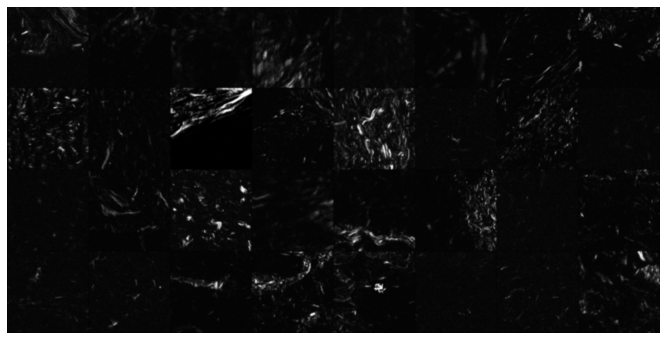

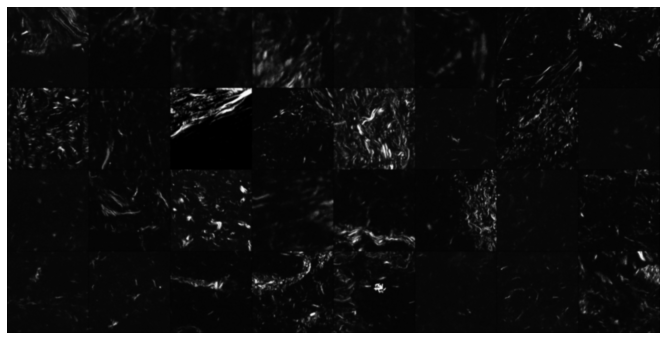

In [53]:
print_output(generator, p, 50, valid_dataset)